<a href="https://www.kaggle.com/code/chickenugget/bert-model?scriptVersionId=104397145" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Creating BERT Model 

### Load the dataset from kaggle's data directory.
Check the working directory of kaggle's dataset and load its train dataset. Remove NaN values if any to ensure code runs smoothly and reduce inaccuraries.

In [1]:
import numpy as np
import pandas as pd
import os
os.listdir('/kaggle/input/feedback-prize-effectiveness')

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']

In [2]:
df_train = pd.read_csv("../input/feedback-prize-effectiveness/train.csv")
df_test = pd.read_csv('../input/feedback-prize-effectiveness/test.csv')
df_submission = pd.read_csv("../input/feedback-prize-effectiveness/sample_submission.csv")

df_train['discourse_text'].isnull().sum() # checks for NAs
df_test['discourse_text'].isnull().sum() # checks for NAs

0

In [3]:
counts = df_train.discourse_effectiveness.value_counts()
print(counts)
print("\nPredicting only 0 = {:.2f}% accuracy".format(counts[0] / sum(counts) * 100))
print("\nPredicting only 1 = {:.2f}% accuracy".format(counts[1] / sum(counts) * 100))
print("\nPredicting only 2 = {:.2f}% accuracy".format(counts[2] / sum(counts) * 100))

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

Predicting only 0 = 57.06% accuracy

Predicting only 1 = 25.37% accuracy

Predicting only 2 = 17.58% accuracy


### Visualize the dataset to determine if data is normal distributed.


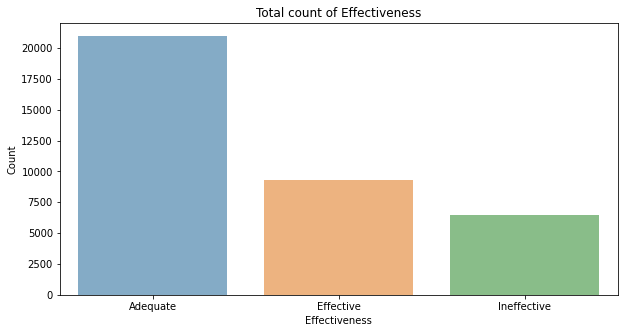

In [4]:
import seaborn as sns 
import matplotlib.pyplot as plt

df_counts = pd.DataFrame(counts).reset_index()
plt.figure(figsize = (10,5))
sns.barplot(x=df_counts['index'],y=df_counts['discourse_effectiveness'],data=df_counts,alpha = 0.6).set_title('Total count of Effectiveness')
plt.xlabel('Effectiveness')
plt.ylabel('Count')
plt.show()

It can be observed that there are more Adequate feedbacks than Effective and Ineffective, indicating that the data may be imbalanced and may be prone to lower prediction accuracy. Possibly, balance the dataset via SMOTE() or other re-sampling methods to make the data to be normally distributed. However in this practice, re-sampling will not be used to allow actual and realistic represenation of the dataset given.

## 1. Data Pre-processing:
### 1.1. Initialize dimension arrays of train dataset.

In [5]:
seq_len = 256  # no. of tokens within each samples 
num_samples = len(df_train) # no. of samples

X_ids = np.zeros((num_samples, seq_len))
X_mask = np.zeros((num_samples, seq_len)) # masking text to allow BERT model to predict text, this avoid the model having connection with actual text and padding tokens.

X_ids.shape
X_ids

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Note: To run Bert tokenizer offline, manually download its file from official huggingface site: https://huggingface.co/bert-base-cased/tree/main,  into a folder and add file data from your computer into Kaggle to run the libary offline. The following files downloaded and used for BERT (bert-base-cased) tokenizer are:

* config.json
* tf_model.h5
* tokenizer_config.json
* tokenizer.json
* vocab.txt

If you are using Pytoch, download other files and exclude tf_model.h5 which is for tensorflow libary. 



### 1.2. Initiate token sequences and paddings using Bert-based case.

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("../input/bertbasecase/bert-base-cased")
tokenizer.save_pretrained('.')

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

### 1.3 Loop the tokenizer for each sample.
* ##### Turncation to cut off text that is longer than seq_length of tokens to be consistent in its dimension arrays.
* ##### Padding text to seq_length for consistency if text are too short.

In [7]:
for i, text in enumerate(df_train['discourse_text']):
    tokens = tokenizer.encode_plus(text, max_length=seq_len, truncation=True, 
                                   padding = 'max_length', add_special_tokens=True
                                   )
    X_ids[i, :] = tokens['input_ids']
    X_mask[i, :] = tokens['attention_mask']
    
X_ids # [CLS] start sequence token is value 101, the 0's are padding sequence to fill up text up to seq_len, values are the same indicating duplicate sequences or text.
X_mask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

### 1.4 Define data class by either manually code into arrays or using other method such as one-hot encoding.


In [8]:
df_train['discourse_effectiveness_cat_codes'] = None
df_train['discourse_effectiveness_cat_codes'] = df_train['discourse_effectiveness'].astype('category')
df_train['discourse_effectiveness_cat_codes'] = df_train['discourse_effectiveness_cat_codes'].cat.codes


coded_effects = df_train['discourse_effectiveness_cat_codes'].values
labels = np.zeros((num_samples, coded_effects.max()+1)) # total categories = 3, so take max value of the category (2) + 1 count to get total of 3 category labels. 
labels.shape
labels[np.arange(num_samples), coded_effects ] = 1
labels 

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

##### Check the category codes by printing the train dataset below. It can be seen that category code 0 = 'Adequate', 1 = 'Effective' and 2 = 'Ineffective'.

In [9]:
print(df_train)

       discourse_id      essay_id  \
0      0013cc385424  007ACE74B050   
1      9704a709b505  007ACE74B050   
2      c22adee811b6  007ACE74B050   
3      a10d361e54e4  007ACE74B050   
4      db3e453ec4e2  007ACE74B050   
...             ...           ...   
36760  9f63b687e76a  FFA381E58FC6   
36761  9d5bd7d86212  FFA381E58FC6   
36762  f1b78becd573  FFA381E58FC6   
36763  cc184624ca8e  FFA381E58FC6   
36764  c8a973681feb  FFA381E58FC6   

                                          discourse_text  \
0      Hi, i'm Isaac, i'm going to be writing about h...   
1      On my perspective, I think that the face is a ...   
2      I think that the face is a natural landform be...   
3      If life was on Mars, we would know by now. The...   
4      People thought that the face was formed by ali...   
...                                                  ...   
36760  For many people they don't like only asking on...   
36761  also people have different views and opinions ...   
36762  Advice i

## 2. Pipeline dataset
### 2.1 Using tensorflow libaries to transform data easily via mapping input ids, mask and labels.

In [10]:
import tensorflow as tf
df_tf = tf.data.Dataset.from_tensor_slices((X_ids, X_mask, labels))
df_tf

# Check the shape of the id, mask and labels.
X_ids[0,:].shape
X_mask[0, :].shape
labels[0, :].shape

# Define map function to allow tensorflow to map correct input into the model
def map_function(input_ids, masks, labels):
    return{'input_ids' : input_ids, 'attention_mask' : masks}, labels

df_tf = df_tf.map(map_function)      

batch_size = 16                                         


2022-08-28 18:22:23.302796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 18:22:23.472174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 18:22:23.473188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 18:22:23.476543: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

##### Shuffle data to prevent overfitting and drop remainder of samples of each batch size of 50 during shuffling. If data not being shuffled, increase the value of the shuffle size.

In [11]:
df_tf = df_tf.shuffle(10000).batch(batch_size, drop_remainder = True) 
df_tf.take(1)

<TakeDataset shapes: ({input_ids: (16, 256), attention_mask: (16, 256)}, (16, 3)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

### 2.2 Train-Test split to train model and validate on test set.



In [12]:
# (Optional method if planning to use sklearn libaries to do train-test split. Note: do make sure the below codes are also changed to X_train, X_test, y_train and y_test instead of df_tf_train and df_tf_test to ensure that code is working)
# from sklearn.model_selection import train_test_split, GridSearchCV 
# X_train, X_test, y_train, y_test = train_test_split(df_train['discourse_text'].values, df_train[['Adequate', 'Effective','Ineffective']].values, stratify=df_feeds['discourse_effectiveness'],test_size=0.3, random_state=100)

In [13]:
split = 0.9
size = int((num_samples / batch_size) * split) 
df_tf_train = df_tf.take(size)
df_tf_test = df_tf.skip(size)
print(df_tf_test)

# del df_tf (Optional to remove unused memory from kernel)


<SkipDataset shapes: ({input_ids: (16, 256), attention_mask: (16, 256)}, (16, 3)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>


## 3. Building BERT model 
### 3.1 Input BERT layer pre-trained case into the Deep Neural Network Layers.

In [14]:
from transformers import TFAutoModel
bert_model = TFAutoModel.from_pretrained('../input/bertbasecase/bert-base-cased')
bert_model.summary()

## input ids and mask layers from map_function into the deep neural network
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
print(input_ids)
print(mask)

# Embedded input and mask layers into BERT model by accessing the transfomer within BERT object
embeddings = bert_model.bert(input_ids, attention_mask=mask)[1]  # using [1] pools  3D tensor from last BERT activation layers to 2D tensors for dense layers.
embeddings

Some layers from the model checkpoint at ../input/bertbasecase/bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ../input/bertbasecase/bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.int32, name='input_ids'), name='input_ids', description="created by layer 'input_ids'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.int32, name='attention_mask'), name='attention_mask', description="created by layer 'attention_mask'")


<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert')>

### 3.2 Convert embeddings into label prediction.
**Note:** Do experiment its hidden layers to optimize its output accuracy (low losses + high accuracy) such as the following:
* Adding more hidden layers (Dense(512), Dense(256), Dense(128)... etc), 
* Introducing dropout rates if test data overfits,
* Other activations such as sigmoid or tanh (preferrably for non-binary classifications),
* Try other model such as adding LSTM, GlobalMaxPool1D() or other models available.
* Pools to 3D tensor BERT activation layers.


In [15]:
from tensorflow.keras.layers import Dropout
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(3, activation ='softmax', name = 'bert_output')(x) 

### Alternatively, you can directly specify the no. of category ouput you would like to predict if is known. For this case is 3 category: Adequate, Effective, Ineffective:
#y = tf.keras.layers.Dense(3, activation='softmax')(x)

### 3.3 Compile all inputs, output, optimizers and loss metrics into BERT model.

In [16]:
model_b_nn = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model_b_nn.summary()

import tensorflow_addons as tfa

### Linear Regularization to prevent overfitting and specificy its loss metrics.
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
prec = tf.keras.metrics.Precision(),
recall = tf.keras.metrics.Recall(),
f1 = tfa.metrics.F1Score(num_classes=3,average='macro', threshold=0.5)
            
model_b_nn.compile(optimizer=optimizer, loss=loss, metrics=[acc, prec, recall, f1])

## Train the model
history = model_b_nn.fit(
    df_tf_train,
    validation_data = df_tf_test,
    steps_per_epoch=200,
    epochs=5
)

model_b_nn.save('bert_model')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]                   

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5


2022-08-28 18:22:53.501199: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


200/200 [==============================] - 147s 682ms/step - loss: 0.8910 - accuracy: 0.5847 - precision: 0.6192 - recall: 0.4878 - f1_score: 0.3825 - val_loss: 0.8077 - val_accuracy: 0.6397 - val_precision: 0.6494 - val_recall: 0.6146 - val_f1_score: 0.4333
Epoch 2/5
200/200 [==============================] - 135s 674ms/step - loss: 0.7872 - accuracy: 0.6509 - precision: 0.6632 - recall: 0.6141 - f1_score: 0.4962 - val_loss: 0.7971 - val_accuracy: 0.6517 - val_precision: 0.6574 - val_recall: 0.6291 - val_f1_score: 0.4605
Epoch 3/5
200/200 [==============================] - 134s 673ms/step - loss: 0.7920 - accuracy: 0.6456 - precision: 0.6558 - recall: 0.6050 - f1_score: 0.4927 - val_loss: 0.8038 - val_accuracy: 0.6608 - val_precision: 0.6678 - val_recall: 0.6430 - val_f1_score: 0.4637
Epoch 4/5
200/200 [==============================] - 135s 675ms/step - loss: 0.8202 - accuracy: 0.6297 - precision: 0.6406 - recall: 0.5822 - f1_score: 0.4893 - val_loss: 0.8212 - val_accuracy: 0.6174 - 

2022-08-28 18:34:25.911672: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### 3.4 Visaulize the Train Accuracy, Validation Accuracy, Train Loss and Validation Loss

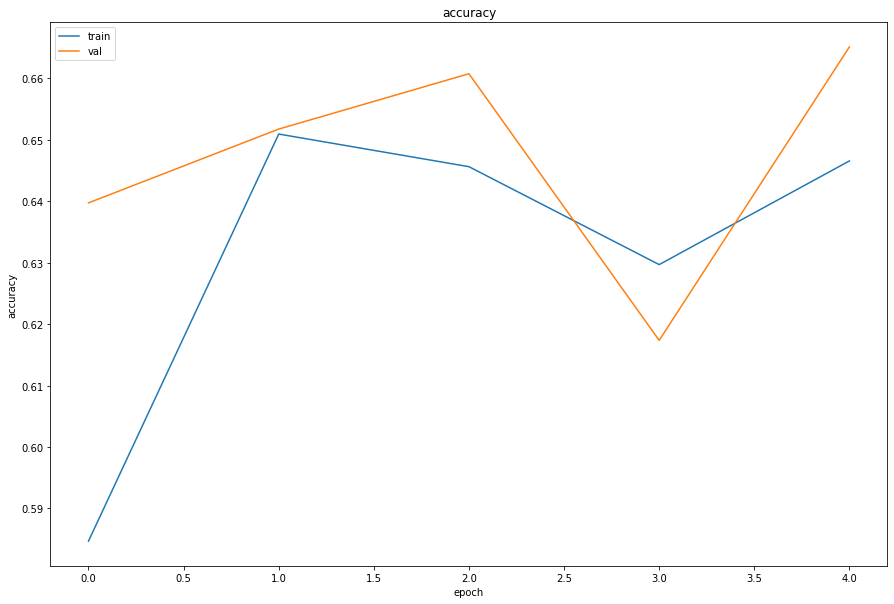

In [17]:
plt.figure(figsize = (15,10))
plt.plot(model_b_nn.history.history['accuracy'])
plt.plot(model_b_nn.history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

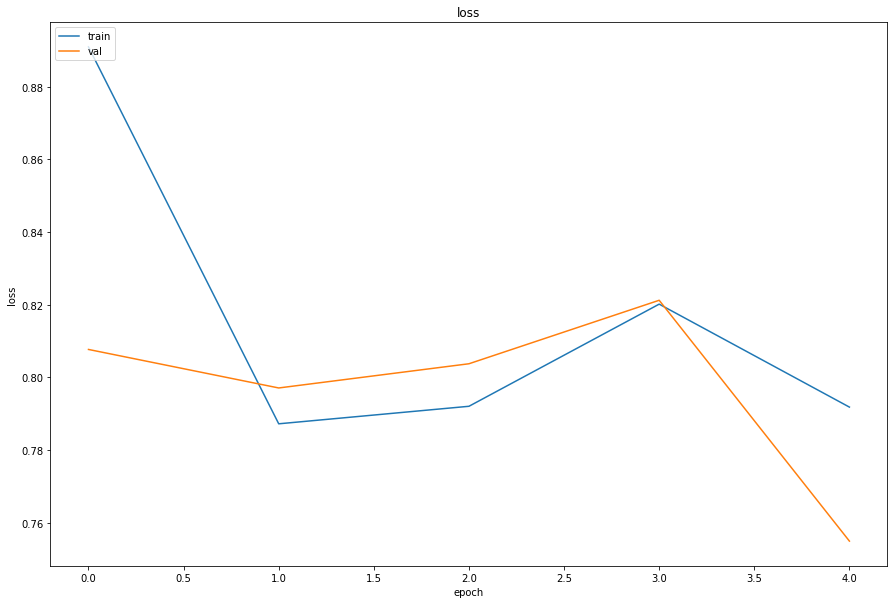

In [18]:
plt.figure(figsize = (15,10))
plt.plot(model_b_nn.history.history['loss'])
plt.plot(model_b_nn.history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 3.5 Predict on test set and compute its loss and accuracy metrices.

In [19]:
predict_test = model_b_nn.evaluate(df_tf_test, return_dict=True, batch_size=batch_size, )
print(predict_test)

229/229 [==============================] - 39s 161ms/step - loss: 0.7650 - accuracy: 0.6643 - precision: 0.6740 - recall: 0.6348 - f1_score: 0.4666
{'loss': 0.7650441527366638, 'accuracy': 0.664301335811615, 'precision': 0.6740075349807739, 'recall': 0.6348253488540649, 'f1_score': 0.4665851294994354}


## 4. Predict on Test set 
### 4.1 Similary, Pre-process test data from step 1.3 by initilizing array of zeros based on length of test data and sequence length of text, followed by iterating Tokenizer text for each row using BERT model and predict the text using previous saved model in 3.3.

In [20]:
X_test_ids = np.zeros((len(df_test), seq_len))
X_test_mask = np.zeros((len(df_test), seq_len))

for i, text in enumerate(df_test['discourse_text']):
    tokens = tokenizer.encode_plus(text, max_length=seq_len, truncation=True, 
                                   padding = 'max_length', add_special_tokens=True,return_token_type_ids=False, return_attention_mask = True,return_tensors='tf' 
                                   )
    X_test_ids[i, :] = tokens['input_ids']
    X_test_mask[i, :] = tokens['attention_mask']
predict_test = model_b_nn.predict([X_test_ids, X_test_mask])

In [21]:
print(predict_test)

[[0.5855732  0.35390297 0.06052385]
 [0.5627439  0.3894969  0.04775922]
 [0.5329002  0.42576063 0.0413392 ]
 [0.69737047 0.2045445  0.09808505]
 [0.6950709  0.2219331  0.08299597]
 [0.4199549  0.5466348  0.03341035]
 [0.43376574 0.52930313 0.03693109]
 [0.6615751  0.2723439  0.06608099]
 [0.5383077  0.36847022 0.09322206]
 [0.60942286 0.31117404 0.07940307]]


### 4.2 Replace values obtained from prediction into submission.csv columns and export its csv file to the competition for grading.

In [22]:
df_submission.iloc[:,1] = predict_test[:,2]
df_submission.iloc[:,2] = predict_test[:,0]
df_submission.iloc[:,3] = predict_test[:,1]
print(df_submission)
df_submission.to_csv('submission.csv', index=False)

   discourse_id  Ineffective  Adequate  Effective
0  a261b6e14276     0.060524  0.585573   0.353903
1  5a88900e7dc1     0.047759  0.562744   0.389497
2  9790d835736b     0.041339  0.532900   0.425761
3  75ce6d68b67b     0.098085  0.697370   0.204544
4  93578d946723     0.082996  0.695071   0.221933
5  2e214524dbe3     0.033410  0.419955   0.546635
6  84812fc2ab9f     0.036931  0.433766   0.529303
7  c668ff840720     0.066081  0.661575   0.272344
8  739a6d00f44a     0.093222  0.538308   0.368470
9  bcfae2c9a244     0.079403  0.609423   0.311174


**References:**

* https://github.com/jamescalam/transformers/tree/main/course/project_build_tf_sentiment_model
* https://www.youtube.com/watch?v=pjtnkCGElcE